### Figure 2: 
### _Light Cone_

---

In this experiment we consider the TDVP2+Ancillary Krylov subspace expansion method for Hamiltonian time evolution 
$$
|\psi(t)\rangle=\mathrm{e}^{-\mathrm{i} t H}|\psi(0)\rangle$$
for  the hamiltonian 
$$H=\frac{1}{2} \sum_{1 \leq i<j \leq n} \frac{J}{|i-j|^\alpha}\left(X_i X_j+Y_i Y_j\right)$$

$\text { with } \alpha=1.5, n=101$. In particular, we kick the midpoint site with magnetization following 
$$
|\psi(0)\rangle=\mathrm{e}^{\mathrm{i}(\pi / 4) Y_{\lceil N / 2\rceil}}\left|\psi_{\min }\right\rangle$$

where  $\left|\psi_{\min }\right\rangle$ is the groundstate of H obtained via DMRG2.

Since this experiment is very expensive for large systems we visualize the precomputed data. To access the experimental drivers see `/experiments/tdvp_light_cone.ipynb` where both the basic TDVP2 and Krylov TDVP2 versions are available 

In [1]:
import sys
import csv
import numpy as np
sys.path.append("../util")
from plotting import *

### Result

---

In [2]:
np.random.seed(42)
#=================Driver=================
N = 101
dt = 0.2
alpha = 1.5
steps = 3
#stop = Cutoff(1e-4)
basis_size=3
max_time_per_iteration = 480 # 8 minute budget
contraction_types =['random','density','zipup','naive']     # ['random','density','zipup','naive']  

### CSV Recovery 


In [7]:
N = 101  
steps = 25  
contraction_types = ['naive', 'random', 'density', 'zipup'] 
basis_size = 3  

results = {
    'mags_modified': {ct: np.full((N, steps), np.nan) for ct in ['naive', 'random']},
    'mags_diff': {ct: np.full((N, steps), np.nan) for ct in ['naive', 'random']},
    'krylov_times': {ct: [] for ct in contraction_types + ['baseline']},
    'expand_times': {ct: [] for ct in contraction_types + ['baseline']},
    'tdvp_times': {ct: [] for ct in contraction_types + ['baseline']},
    'bond_dim': {ct: [] for ct in contraction_types + ['baseline']},
    # Adjust evolution_errors to hold only basis_size - 1 vectors (since we skip the first one)
    'evolution_errors': {ct: np.zeros((basis_size - 1, steps)) for ct in ['zipup', 'random']}
}

file_path = 'data/fig2_final.csv'

with open(file_path, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if len(row) < 8:
            continue  

        t = int(row[0])  # Time step index
        contraction_type = row[1]  # Contraction type

        mags_modified = np.array(list(map(float, row[2].strip('"').split(',')))) if row[2] else None
        mags_diff = np.array(list(map(float, row[3].strip('"').split(',')))) if row[3] else None

        krylov_time = float(row[4]) if row[4] else np.nan
        expand_time = float(row[5]) if row[5] else np.nan
        tdvp_time = float(row[6]) if row[6] else np.nan
        bond_dim = int(row[7]) if row[7] else np.nan

        if contraction_type in ['zipup', 'random'] and len(row) > 8:
            # Skip the first Krylov vector's evolution error and store the next two
            evolution_errors = np.array(list(map(float, row[9:9 + (basis_size - 1)])))  # Start from index 9 to skip the first one
            results['evolution_errors'][contraction_type][:, t] = evolution_errors

        if contraction_type in ['naive', 'random']:
            if mags_modified is not None and t < steps:
                results['mags_modified'][contraction_type][:, t] = mags_modified
            if mags_diff is not None and t < steps:
                results['mags_diff'][contraction_type][:, t] = mags_diff

        results['krylov_times'][contraction_type].append(krylov_time)
        results['expand_times'][contraction_type].append(expand_time)
        results['tdvp_times'][contraction_type].append(tdvp_time)
        results['bond_dim'][contraction_type].append(bond_dim)

print("Data successfully recovered from the CSV file.")

Data successfully recovered from the CSV file.


### Light Cone 
---

In [8]:
random_times = results["krylov_times"]["random"]
zipup_times = results["krylov_times"]["zipup"]
naive_times = results["krylov_times"]["naive"]
density_times = results["krylov_times"]["density"]

def calculate_speedup(method_times, random_times):
    min_length = min(len(method_times), len(random_times))
    return np.array(method_times[:min_length]) / np.array(random_times[:min_length])

zipup_speedup = calculate_speedup(zipup_times, random_times)
naive_speedup = calculate_speedup(naive_times, random_times)
density_speedup = calculate_speedup(density_times, random_times)

mean_zipup_speedup = np.mean(zipup_speedup)
mean_naive_speedup = np.mean(naive_speedup)
mean_density_speedup = np.mean(density_speedup)

print("Mean speedup for random over zipup:", mean_zipup_speedup)
print("Mean speedup for random over naive:", mean_naive_speedup)
print("Mean speedup for random over density:", mean_density_speedup)

Mean speedup for random over zipup: 2.976557740142559
Mean speedup for random over naive: 158.3775571639178
Mean speedup for random over density: 39.13975600830586


In [9]:
random_times = results["krylov_times"]["random"]
zipup_times = results["krylov_times"]["zipup"]
naive_times = results["krylov_times"]["naive"]
density_times = results["krylov_times"]["density"]

def calculate_speedup(method_times, random_times):
    min_length = min(len(method_times), len(random_times))
    return np.array(method_times[:min_length]) / np.array(random_times[:min_length])

zipup_speedup = calculate_speedup(zipup_times, random_times)
naive_speedup = calculate_speedup(naive_times, random_times)
density_speedup = calculate_speedup(density_times, random_times)

extreme_zipup_speedup = np.max(zipup_speedup)
extreme_naive_speedup = np.max(naive_speedup)
extreme_density_speedup = np.max(density_speedup)

argmax_zipup_speedup = np.argmax(zipup_speedup)
argmax_naive_speedup = np.argmax(naive_speedup)
argmax_density_speedup = np.argmax(density_speedup)

# Print the most extreme speedups and their argmax indices
print("Most extreme speedup for random over zipup:", extreme_zipup_speedup, "at index", argmax_zipup_speedup,"/",len(zipup_times))
print("Most extreme speedup for random over naive:", extreme_naive_speedup, "at index", argmax_naive_speedup,"/",len(naive_times))
print("Most extreme speedup for random over density:", extreme_density_speedup, "at index", argmax_density_speedup,"/",len(density_times))

Most extreme speedup for random over zipup: 3.2839896816412355 at index 0 / 24
Most extreme speedup for random over naive: 181.58370276743875 at index 6 / 9
Most extreme speedup for random over density: 45.13632931006243 at index 0 / 20


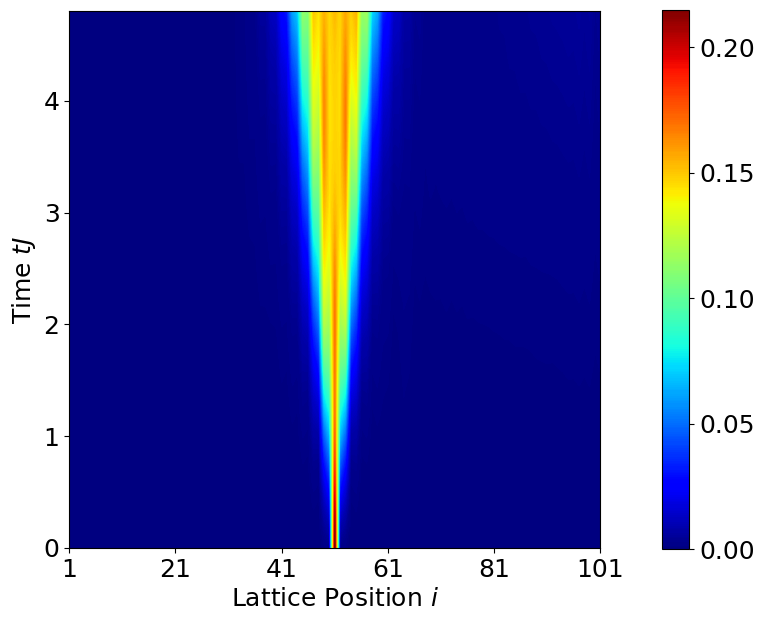

In [10]:
final_plots(results,N,dt)

### Bond Dimension
 ---
 

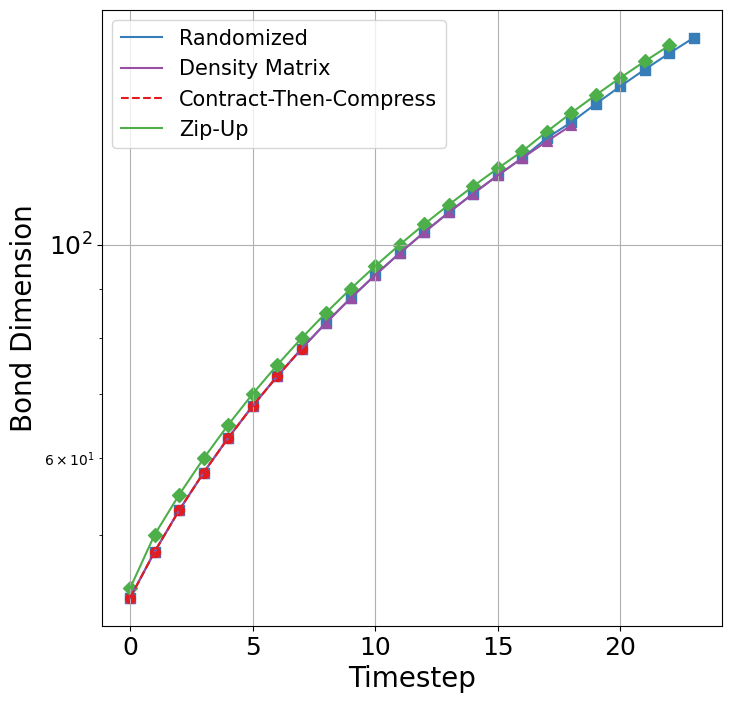

In [12]:
bond_dims = bond_dimensions(results)
plot_bond_dimensions(bond_dims)

### Expand Times
---

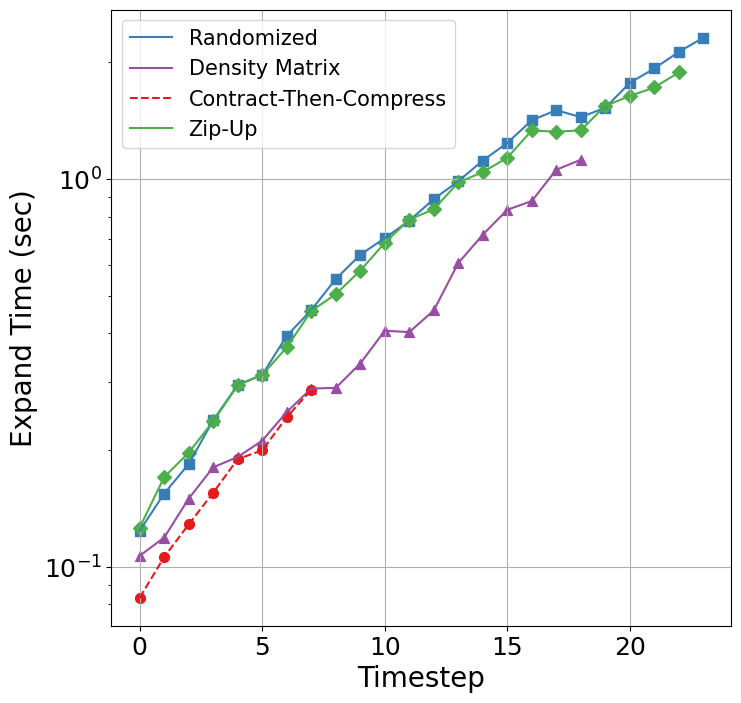

In [13]:
expand_times = expand_times_runtime(results)
plot_expand_times(expand_times)

### Krylov Times
---

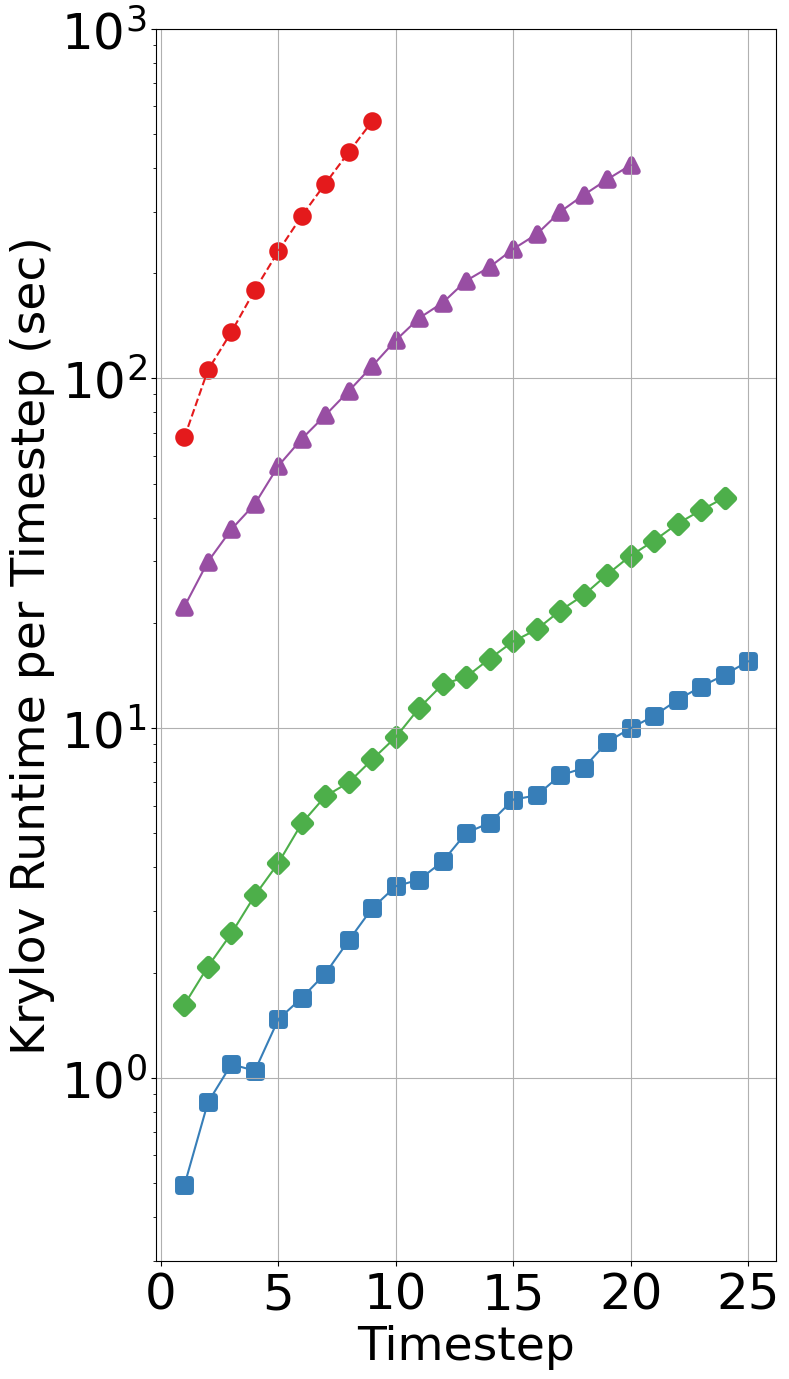

In [14]:

krylov_times = krylov_times_runtime(results)
plot_krylov_times(krylov_times)

### Total Times: Expand+Krylov+TDVP
--- 


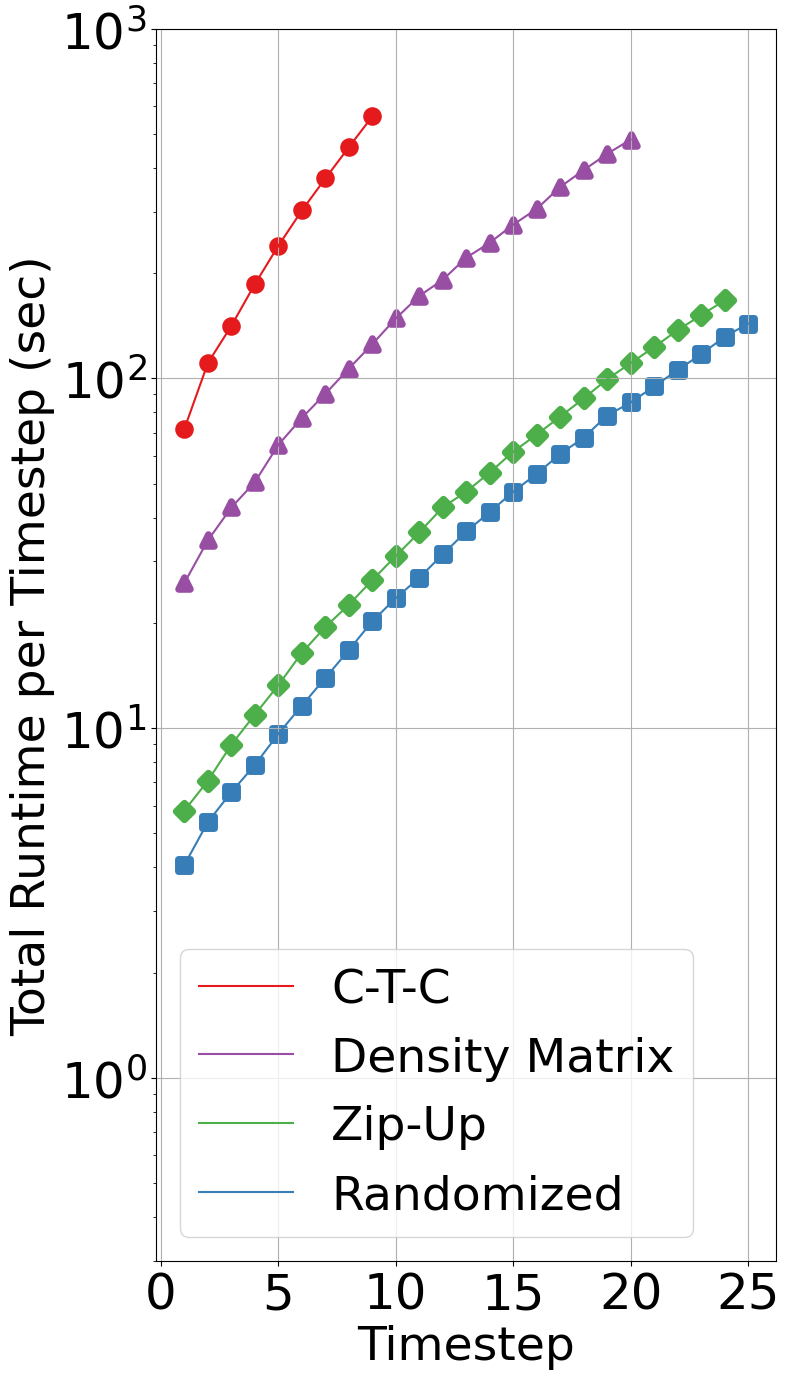

krylov


In [15]:
total_times = total_runtime(results)
plot_total_times(total_times)
print("krylov")